<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Behavior Neuropixels Optotagging Tutorial SWDB 2022 </h1> 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>This notebook will introduce you to optotagging in the Visual Behavior Neuropixels dataset and associated AllenSDK functions. 
    

### Why optotagging?
    
* In extracellular electrophysiology, we have very little information about cell types, beyond simple metrics like waveform duration

* One way to record from genetically-identified cell types is to express channelrhodopsin with a transgenic mouse, then shine light on the brain during a recording

* The units that are activated strongly by the light likely express channelrhodopsin, and therefore belong to the genetically defined cell type of interest

* However, there is not one generally accepted method for defining whether a cell has been optotagged. The strength of response to light is determined by many factors, including light power, location/spread of illumination, depth in the brain, level of channelrhodopsin expression, and more.

* Below we will show one example method of defining which cells are optotagged



In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## Access the dataset

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"

In [3]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# this path should point to the location of the dataset on your platform
#cache_dir = r"/Volumes/programs/mindscope/workgroups/np-behavior/vbn_data_release/vbn_s3_cache"
cache_dir = r"\\allen\programs\mindscope\workgroups\np-behavior\vbn_data_release\vbn_s3_cache"

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(
            cache_dir=cache_dir)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## Filtering the sessions table for a session of interest
    
<p>Let's grab the same session as we did in the tutorial, since it fulfilled these criteria:

- `Novel` images presented
- `Sst-IRES-Cre` mouse

In [28]:
ecephys_sessions_table = cache.get_ecephys_session_table()

sst_novel_sessions = ecephys_sessions_table.loc[(ecephys_sessions_table['genotype'].str.contains('Sst')) & 
                                            (ecephys_sessions_table['experience_level']=='Novel')]
sst_novel_sessions.head(1)

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1053941483,1053960987,2020-10-01 17:03:58.362,NP.1,EPHYS_1_images_H_3uL_reward,527749,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,180,1543.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,6,NaN,NaN


In [27]:
session_id = 1053941483
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\hdmf\spec\namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Load units, channels, and spike_times

Now, let's load the units, channels, and spike_times, and merge the units and channels tables as in the first tutorial

In [29]:
units = session.get_units()
channels = session.get_channels()
units = units.merge(channels, left_on='peak_channel_id', right_index=True)

spike_times = session.spike_times

We will use the <code>makePSTH</code> and <code>make_neuron_time_trials_tensor</code> functions, so we should define them here or import them

In [9]:
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    '''
    Convenience function to compute a peri-stimulus-time histogram
    (see section 7.2.2 here: https://neuronaldynamics.epfl.ch/online/Ch7.S2.html)
    INPUTS:
        spikes: spike times in seconds for one unit
        startTimes: trial start times in seconds; the first spike count 
            bin will be aligned to these times
        windowDur: trial duration in seconds
        binSize: size of spike count bins in seconds
    OUTPUTS:
        Tuple of (PSTH, bins), where:
            PSTH gives the trial-averaged spike rate for 
                each time bin aligned to the start times;
            bins are the bin edges as defined by numpy histogram
    '''
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/len(startTimes)
    return counts/binSize, bins


def make_neuron_time_trials_tensor(units, stim_table, 
                                   time_before, trial_duration,
                                   bin_size=0.001):
    '''
    Function to make a tensor with dimensions [neurons, time bins, trials] to store
    the spike counts for stimulus presentation trials. 
    INPUTS:
        units: dataframe with unit info (same form as session.units table)
        stim_table: dataframe whose indices are trial ids and containing a
            'start_time' column indicating when each trial began
        time_before: seconds to take before each start_time in the stim_table
        trial_duration: total time in seconds to take for each trial
        bin_size: bin_size in seconds used to bin spike counts 
    OUTPUTS:
        unit_tensor: tensor storing spike counts. The value in [i,j,k] 
            is the spike count for neuron i at time bin j in the kth trial.
    '''
    neuron_number = len(units)
    trial_number = len(stim_table)
    unit_tensor = np.zeros((neuron_number, int(trial_duration/bin_size), trial_number))
    
    for u_counter, (iu, unit) in enumerate(units.iterrows()):
        unit_spike_times = spike_times[iu]
        for t_counter, (it, trial) in enumerate(stim_table.iterrows()):
            trial_start = trial.start_time - time_before
            unit_tensor[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
                                                            [trial_start], 
                                                            trial_duration, 
                                                            binSize=bin_size)[0]
    return unit_tensor

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Using Optotagging to Identify SST Neurons
Since this is an SST mouse, we should see putative SST+ interneurons that are activated during our optotagging protocol. Let's load the optotagging stimulus table and plot PSTHs triggered on the laser onset. For more examples and useful info about optotagging, you can check out the Visual Coding Neuropixels Optotagging notebook [here](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html) (though note that not all the functionality in the visual coding SDK will work for this dataset).

In [10]:
opto_table = session.optotagging_table
opto_table.head()

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,8819.44710,a single square pulse,0.78,8819.45710,pulse,0.01
1,8821.29822,half-period of a cosine wave,1.70,8822.29822,raised_cosine,1.00
2,8823.42800,half-period of a cosine wave,1.00,8824.42800,raised_cosine,1.00
3,8825.25781,half-period of a cosine wave,0.78,8826.25781,raised_cosine,1.00
4,8827.25599,a single square pulse,1.70,8827.26599,pulse,0.01


<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/42/a9/42a97aa9-910a-4e62-9b1a-62c26eab3772/opto_waveforms.png", width="700"/>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

If you check out the above table and diagram, you'll see that we use 2 different laser waveforms: a half-period cosine wave that's 1 second long and a short square pulse that's 10 ms long. We drive each at three light levels, giving us 6 total conditions. Now let's plot how cortical neurons respond to the short pulse at high power.

In [11]:
#first let's sort our units by depth
units = units.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them for good units
good_unit_filter = ((units['snr']>1)&             
                    (units['isi_violations']<1)& 
                    (units['firing_rate']>0.1)&   
                    (units['quality']=='good'))  

area_filter = units['structure_acronym'].str.contains('VIS')
cortical_units = units[good_unit_filter & area_filter]

#Make tensor
time_before_laser = 0.5
trial_duration = 1.5
bin_size = 0.001
time_array = np.arange(-time_before_laser,trial_duration-time_before_laser,bin_size)
opto_array = make_neuron_time_trials_tensor(cortical_units, opto_table, time_before_laser, trial_duration, bin_size)

(-10.0, 20.0)

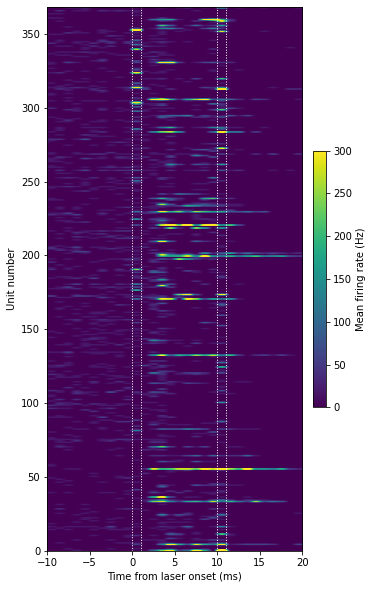

In [12]:
#Grab the short pulse + high power trials
duration = opto_table.duration.min()
level = opto_table.level.max()

#Find the indicies of trials with this duration and level
sel_trials=((opto_table['duration']==duration)&(opto_table['level']==level)).values

#Average over these selected trials
mean_opto_responses=np.nanmean(opto_array[:,:,sel_trials],2)

#find the time indices for a short window before and after optogenetic stimulation
time_idx = (time_array>=-0.05)&(time_array<0.05)

#Now plot a heatmap across units showing how they responded to the laser
fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,10))

im=ax.imshow(mean_opto_responses[:,time_idx],
             extent=[-50, 50, 0, mean_opto_responses.shape[0]], 
             origin='lower', aspect='auto')
min_clim_val = 0
max_clim_val = 300
im.set_clim([min_clim_val, max_clim_val])    
[ax.axvline(bound, linestyle=':', color='white', linewidth=1.0)\
     for bound in [0,1,11, 10]]
ax.set_xlabel('Time from laser onset (ms)')
ax.set_ylabel('Unit number')
cb = plt.colorbar(im,fraction=0.046, pad=0.04)
cb.set_label('Mean firing rate (Hz)')

ax.set_xlim([-10,20])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Here we can see that most units don't respond to the short laser pulse. But there is a population of ~40 units that do show elevated firing rates. Note that the activity occurring at the onset and offset of the laser (along the dotted lines) is likely artifactual and should be excluded from analysis.

There are multiple ways to define which units are optotagged and therefore Cre-positive. We will just show one set of optotagging criteria. You can even try to define your own criteria!

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Optotagging guidelines 

There are a variety of ways to define optotagged cells, but these are the most important things to keep in mind:

- Spikes that occur precisely at the start or end of a light pulse are likely artifactual, and need to be ignored.
- The bright blue light required for optotagging can be seen by the mouse, so any spikes that occur more than 40 ms after the stimulus onset may result from retinal input, as opposed to direct optogenetic drive.
- The rate of false negatives (Cre+ cells that are not light-driven) will vary across areas, across depths, and across sessions. We've tried our best to evenly illuminate the entire visual cortex, and to use light powers that can drive spikes throughout all cortical layers, but some variation is inevitable.

For these reasons, we've found that the 10 ms pulses are the most useful stimulus for finding true light-evoked activity. These pulses provide a long enough artifact-free window to observe light-evoked spikes, but do not last long enough to be contaminated by visually driven activity.
    
Using the 3D array we created previously, we can search for units that increase their firing rate during the 10 ms pulse:

In [13]:
# slice our data array to take the baseline period (before the laser turns on)
baseline_time_idx = (time_array>=-0.010)&(time_array<0.002)

# then average over this time window in the mean_opto_responses to get the baseline rate for each unit
baseline_rate = np.mean(mean_opto_responses[:,baseline_time_idx],1)

# do the same for the period when the laser was on to get the evoked rate for each unit
evoked_rate_idx = (time_array>=0.001)&(time_array<0.009)
evoked_rate = np.mean(mean_opto_responses[:,evoked_rate_idx],1)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Comparing the baseline and evoked rates, we can see a clear subset of units with a light-evoked increase in firing rate: 

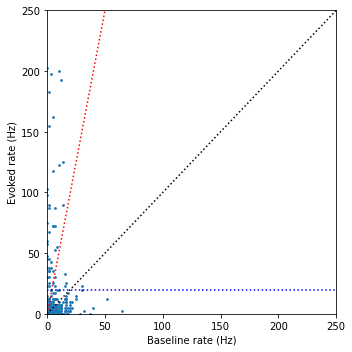

In [30]:
increase_in_FR = 5 #multiple increase over baseline rate
min_evoked_rate = 20 #Hz

fig,ax=plt.subplots(1,1,figsize=(5,5))

ax.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 250
ax.plot([0,axis_limit],[0,axis_limit], ':k')
ax.plot([0,axis_limit],[0,axis_limit*increase_in_FR], ':r')
ax.axhline(min_evoked_rate,color='b',linestyle=':')
ax.set_xlim([0,axis_limit])
ax.set_ylim([0,axis_limit])

ax.set_xlabel('Baseline rate (Hz)')
ax.set_ylabel('Evoked rate (Hz)')

fig.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can select a threshold, such as 5x increase in firing rate (red line), plus an evoked rate of at least 20Hz (blue line), to find the IDs for units that are robustly driven by the light:

In [31]:
cre_pos_idx = (evoked_rate > min_evoked_rate) & ((evoked_rate / (baseline_rate + 1)) > increase_in_FR) # add 1 to prevent divide-by-zero errors
cre_pos_unit_ids = cortical_units[cre_pos_idx==True].index

cre_pos_units = cortical_units.loc[cre_pos_unit_ids]
cre_pos_units.head(2)

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,waveform_duration,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,filtering,left_right_ccf_coordinate,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym
id,,,,,,,,,,,,,,,,,,,,,
1061855316,0.339354,158.830425,0.5,227,600.68,6.073243,2.009925,0.468226,79.148518,0.000153,...,0.549414,7113.0,996.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,8718.0,350,59,1054059294,3520,VISrl
1061855053,0.675283,130.541385,0.5,251,264.21,4.041208,5.054706,0.203606,100.591144,0.001928,...,0.480737,8426.0,1937.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,9891.0,342,59,1054059293,3440,VISal


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Plotting the PSTHs from these putative optotagged units shows that they do appear to be activated by the optogenetic stimulation:

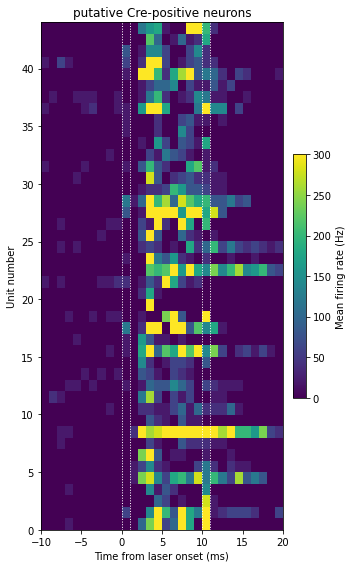

In [16]:
#Grab the short pulse + high power trials
duration = opto_table.duration.min()
level = opto_table.level.max()

#Find the indicies of trials with this duration and level
sel_trials=((opto_table['duration']==duration)&(opto_table['level']==level)).values

#Average over these selected trials
cre_pos_array=opto_array[cre_pos_idx,:,:]
mean_opto_responses=np.nanmean(cre_pos_array[:,:,sel_trials],2)

#find the time indices for a short window before and after optogenetic stimulation
time_idx = (time_array>=-0.05)&(time_array<0.05)

fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,8))

im=ax.imshow(mean_opto_responses[:,time_idx],
             extent=[-50, 50, 0, mean_opto_responses.shape[0]], 
             origin='lower', aspect='auto')
min_clim_val = 0
max_clim_val = 300
im.set_clim([min_clim_val, max_clim_val])    
[ax.axvline(bound, linestyle=':', color='white', linewidth=1.0)\
     for bound in [0,1,11,10]]
ax.set_xlabel('Time from laser onset (ms)')
ax.set_ylabel('Unit number')
cb = plt.colorbar(im,fraction=0.046, pad=0.04)
cb.set_label('Mean firing rate (Hz)')

ax.set_xlim([-10,20])
ax.set_title('putative Cre-positive neurons')
fig.tight_layout()

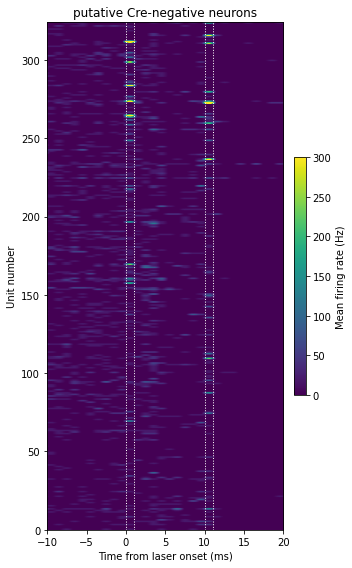

In [17]:
cre_neg_idx = ~cre_pos_idx
cre_neg_unit_ids = cortical_units[cre_neg_idx==True].index

cre_neg_units = cortical_units.loc[cre_neg_unit_ids]
cre_neg_units.head(2)

fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,8))

#Average over these selected trials
cre_neg_array=opto_array[cre_neg_idx,:,:]
mean_opto_responses=np.nanmean(cre_neg_array[:,:,sel_trials],2)

im=ax.imshow(mean_opto_responses[:,time_idx],
             extent=[-50, 50, 0, mean_opto_responses.shape[0]], 
             origin='lower', aspect='auto')
min_clim_val = 0
max_clim_val = 300
im.set_clim([min_clim_val, max_clim_val])    
[ax.axvline(bound, linestyle=':', color='white', linewidth=1.0)\
     for bound in [0,1,10,11]]
ax.set_xlabel('Time from laser onset (ms)')
ax.set_ylabel('Unit number')
cb = plt.colorbar(im,fraction=0.046, pad=0.04)
cb.set_label('Mean firing rate (Hz)')

ax.set_xlim([-10,20])
ax.set_title('putative Cre-negative neurons')
fig.tight_layout()

Feel free to experiment with changing the optotagging criteria above, or create entirely new ones!

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Plotting responses of SST neurons to novel and familiar images

Now that we have identified putative SST neurons, let's plot their responses to familiar vs. novel images, much like we did in the tutorial. All we need to do is divde units into Cre-positive and Cre-negative and plot them separately.

First, load the stimulus_presentations table:

In [20]:
stimulus_presentations = session.stimulus_presentations

Next we need to define which images are novel, which requires the <code>getImageNovelty</code> function again, so we should define it here or import it:

In [18]:
session_id = session.metadata['ecephys_session_id']
is_novel_image_set = ecephys_sessions_table.loc[session_id]['experience_level'] == 'Novel'

IMAGE_SET_KEY={
                'G' : ['im012_r', 'im036_r', 'im044_r', 
                    'im047_r', 'im078_r', 'im115_r'],
                'H' : ['im005_r', 'im024_r', 'im034_r', 
                    'im087_r', 'im104_r', 'im114_r'],
                'shared' : ['im083_r', 'im111_r'],
                'omitted' : 'omitted'
                }

In [19]:
def getImageNovelty(image_name):
    '''
    Function to help annotate the stimulus_presentations table
    to indicate the following info:
        1) whether a given image was:
            a) unique to the G set
            b) unique to the H set
            c) shared across G and H
            d) omitted
        2) whether the image was novel to the mouse
    
    Meant to be run on the image names of the stimulus_presentations table
    
    OUTPUT:
        Tuple indicating (image_set, image_novelty) for one 
        row of the stimulus_presentations table

    '''
    # First check that this image is one of the Natural Images used
    image_in_image_set = any([np.isin(image_name, imset) \
                              for _,imset in IMAGE_SET_KEY.items()]) 
    if not image_in_image_set:
        return np.nan, np.nan

    #Get the image set for this image
    image_set_for_this_image = [name for name, image_set in IMAGE_SET_KEY.items()\
                                if image_name in image_set][0]
    
    #Get the image novelty for this image
    if image_set_for_this_image == 'omitted':
        novelty_for_this_image = np.nan
    else:
        novelty_for_this_image = (is_novel_image_set) and \
                            (np.isin(image_set_for_this_image, ['G', 'H']))
    

    return image_set_for_this_image, novelty_for_this_image

In [21]:
image_info = stimulus_presentations.apply(lambda row: getImageNovelty(row['image_name']), axis=1)  
stimulus_presentations['image_set'] = [i[0] for i in image_info]
stimulus_presentations['is_novel'] = [i[1] for i in image_info]

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
#Grab the portion of the stim table that describes the active behavior stimuli
task_stim_table = stimulus_presentations[stimulus_presentations['active']]

#Make tensor
time_before_flash = 1.0
trial_duration = 2.0
bin_size = 0.001

time_array=np.arange(-time_before_flash,trial_duration-time_before_flash,bin_size)

cre_pos_stim_array = make_neuron_time_trials_tensor(cre_pos_units, task_stim_table, time_before_flash, trial_duration)
cre_neg_stim_array = make_neuron_time_trials_tensor(cre_neg_units, task_stim_table, time_before_flash, trial_duration)

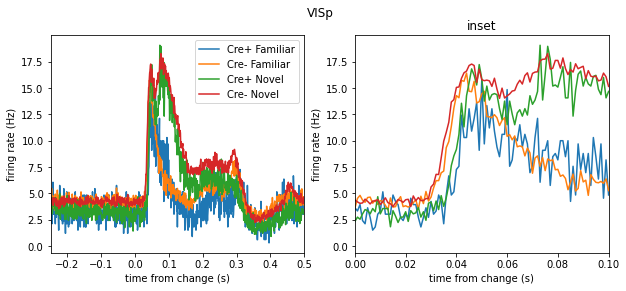

In [26]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches([10, 4])
fig.suptitle('VISp')
for isnovel in [False, True]:
    # First let's find the trial ids for the relevant change stimuli
    trial_ids = task_stim_table[(task_stim_table['is_change'])&(task_stim_table['is_novel']==isnovel)].index.values
    
    # Now let's use those trial ids to select the corresponding cre positive and cre negative unit tables
    cre_pos_relevant_trials = cre_pos_stim_array[:,:,trial_ids]
    cre_neg_relevant_trials = cre_neg_stim_array[:,:,trial_ids]
    
    # Let's now take the mean over units and trials
    cre_pos_mean_over_trials = np.mean(cre_pos_relevant_trials,axis=(0,2))
    cre_neg_mean_over_trials = np.mean(cre_neg_relevant_trials,axis=(0,2))
    
    # Now plot. We're plotting twice to show two time scales, and plotting Cre+ and Cre- as separate lines
    [ax.plot(time_array, cre_pos_mean_over_trials) for ax in axes]
    [ax.plot(time_array, cre_neg_mean_over_trials) for ax in axes]

xlims = ([-0.25, 0.5], [0, 0.1])
for ax, xlim in zip(axes, xlims):
    ax.set_xlabel('time from change (s)')
    ax.set_ylabel('firing rate (Hz)')
    ax.set_xlim(xlim)
axes[1].set_title('inset')
axes[0].legend(['Cre+ Familiar', 'Cre- Familiar', 'Cre+ Novel', 'Cre- Novel'])